Question 1

In [1]:
import os
import sys

from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata

In [2]:
def get_raw_data_from_bio_file(fpath):
    """A simple function to read in from a one-word-per-line BIO
    (Beginning, Inside, Outside) tagged corpus, tab separated
    and each example sentence/text separated with a blank line.
    The data is already tokenized in a simple way.
    e.g.:
    
    O	a
    O	great
    O	lunch
    O	spot
    O	but
    B-Hours	open
    I-Hours	till
    I-Hours	2
    I-Hours	a
    I-Hours	m
    B-Restaurant_Name	passims
    I-Restaurant_Name	kitchen
    
    returns a list of lists of tuples of (word, tag) tuples
    """
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data




In [3]:
def splitData(percentage):
    # A method to split the data between trainData and testData 
    dataSamples = len(raw_training_data)
    halfOfData = int(len(raw_training_data)/2)
    trainingSamples = int((percentage*dataSamples)/2)
    
    
    for instances in raw_training_data[:trainingSamples] + raw_training_data[halfOfData:halfOfData+trainingSamples]:
        trainData.append((preProcess(instances)))
    for labels in raw_training_data[trainingSamples:halfOfData] + raw_training_data[halfOfData+trainingSamples:]:
        testData.append((preProcess(labels)))

In [4]:
raw_training_data = get_raw_data_from_bio_file("engtrain.bio.txt") 

In [5]:
# have a look at the first example
print(raw_training_data[0])

[('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]


In [6]:
print(len(raw_training_data), "instances")
print(sum([len(sent) for sent in raw_training_data]), "words")

9775 instances
99491 words


In [7]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""

    preprocessed_example = example  # trivial- no preprocessing
    return preprocessed_example

In [8]:
training_data = [preProcess(example) for example in raw_training_data]


In [9]:
# check the effect of pre-processing
print(training_data[0])

[('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]


In [10]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits

# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list

    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    #print(feature_list)
    return feature_list

In [11]:
# Train the CRF BIO-tag tagger
data = []
current_sent = []
trainData = []
testData = []
splitData(0.8)
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [12]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("engtest.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

2443 instances
24686 words


In [13]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [14]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))

C:\Users\Tariq\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

          B-ACTOR       0.76      0.88      0.81       812
      B-CHARACTER       0.72      0.26      0.38        90
       B-DIRECTOR       0.77      0.61      0.68       456
          B-GENRE       0.91      0.95      0.93      1117
           B-PLOT       0.60      0.40      0.48       491
         B-RATING       0.98      0.97      0.97       500
B-RATINGS_AVERAGE       0.87      0.82      0.84       451
         B-REVIEW       0.14      0.02      0.03        56
           B-SONG       0.69      0.17      0.27        54
          B-TITLE       0.58      0.50      0.54       562
        B-TRAILER       0.80      0.80      0.80        30
           B-YEAR       0.94      0.94      0.94       720
          I-ACTOR       0.75      0.89      0.81       862
      I-CHARACTER       0.76      0.29      0.42        75
       I-DIRECTOR       0.78      0.60      0.68       496
          I-GENRE       0.84      0.71      0.77       

In [15]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    plt.show()

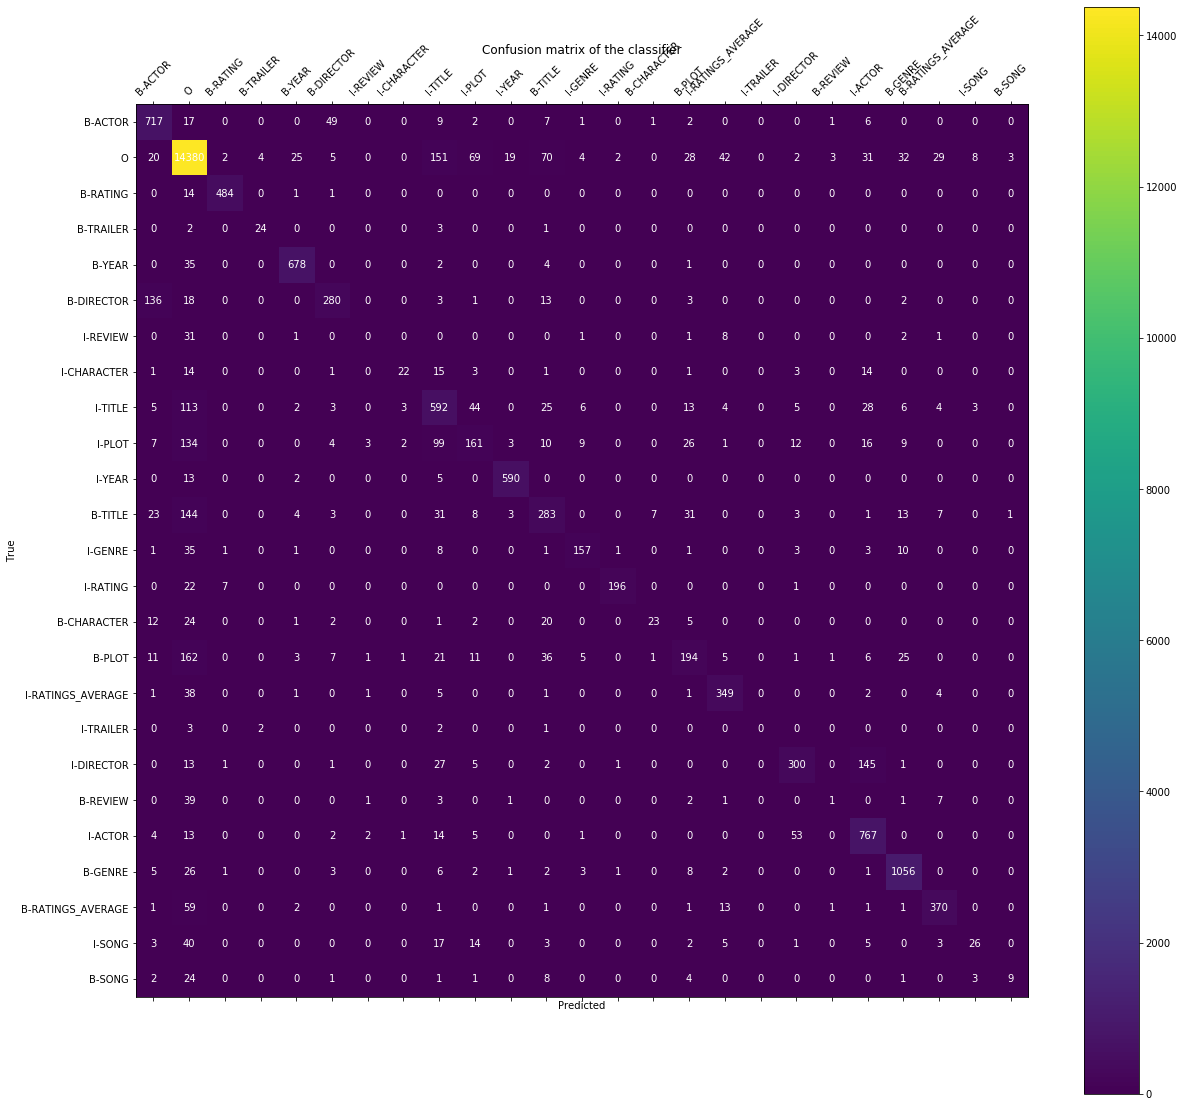

In [16]:
confusion_matrix_heatmap(y_test, preds)

Question 2

In [17]:
print("testing tagger...")
preds = []
y_test = []
lowest_precision = ['I-SONG','I-PLOT','B-SONG','B-PLOT','I-CHARACTER']
for sent in testData:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])] #contains false postives and negatives 
    sent_true = [s[1] for s in sent]#contains only truth value
    
    for fp in lowest_precision:
            positions_pred = [i for i, x in enumerate(sent_preds) if x==fp]
            if positions_pred == []:
                continue
            positions_true = [i for i, x in enumerate(sent_true) if x==fp]
            if len(set(positions_pred) - set(positions_true))>0:
                print("false positive!", fp)
                print(set(positions_pred) - set(positions_true))
                print(sent)
                print(sent_preds)
                print("*" * 30)
        
    
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
false positive! I-PLOT
{6}
[('is', 'O'), ('there', 'O'), ('a', 'O'), ('deep', 'B-PLOT'), ('sea', 'I-PLOT'), ('diver', 'I-PLOT'), ('romance', 'B-GENRE')]
['O', 'O', 'O', 'B-PLOT', 'I-PLOT', 'I-PLOT', 'I-PLOT']
******************************
false positive! I-PLOT
{8, 7}
[('sports', 'B-GENRE'), ('film', 'O'), ('staring', 'O'), ('jamie', 'B-ACTOR'), ('foxx', 'I-ACTOR'), ('and', 'O'), ('ll', 'B-ACTOR'), ('cool', 'I-ACTOR'), ('j', 'I-ACTOR')]
['B-GENRE', 'O', 'O', 'B-ACTOR', 'I-ACTOR', 'O', 'B-PLOT', 'I-PLOT', 'I-PLOT']
******************************
false positive! B-PLOT
{6}
[('sports', 'B-GENRE'), ('film', 'O'), ('staring', 'O'), ('jamie', 'B-ACTOR'), ('foxx', 'I-ACTOR'), ('and', 'O'), ('ll', 'B-ACTOR'), ('cool', 'I-ACTOR'), ('j', 'I-ACTOR')]
['B-GENRE', 'O', 'O', 'B-ACTOR', 'I-ACTOR', 'O', 'B-PLOT', 'I-PLOT', 'I-PLOT']
******************************
false positive! B-PLOT
{5}
[('what', 'O'), ('soundtracks', 'B-SONG'), ('have', 'O'), ('song', 'O'), ('by', 'O'), ('prince

Question 3

In [18]:
print("testing tagger...")
preds = []
y_test = []


lowestprecision = ['B-CHARACTER','B-SONG','B-TITLE','I-SONG','B-PLOT']
for sent in testData:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])] #contains false postives and negatives 
    sent_true = [s[1] for s in sent]#contains only truth value
    falsepredict=[]
    ground_truth=[]

                
    for labels in lowestprecision:
            for i,label in enumerate(sent_preds):
                if label == labels:
                    falsepredict.append(sent[i])
            for j,pos in enumerate(sent_true):
                if pos == labels:
                    ground_truth.append(sent[j])
            if len(set(ground_truth) - set(falsepredict))>0:
                print("false negative!", labels)
                print(set(ground_truth) - set(falsepredict))
                print(sent)
                print(ground_truth)
                print("*" * 30)

    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
false negative! B-SONG
{('florence', 'B-SONG')}
[('has', 'O'), ('florence', 'B-SONG'), ('and', 'I-SONG'), ('the', 'I-SONG'), ('machine', 'I-SONG'), ('been', 'O'), ('on', 'O'), ('any', 'O'), ('movie', 'O'), ('sountracks', 'O')]
[('florence', 'B-SONG')]
******************************
false negative! B-TITLE
{('florence', 'B-SONG')}
[('has', 'O'), ('florence', 'B-SONG'), ('and', 'I-SONG'), ('the', 'I-SONG'), ('machine', 'I-SONG'), ('been', 'O'), ('on', 'O'), ('any', 'O'), ('movie', 'O'), ('sountracks', 'O')]
[('florence', 'B-SONG')]
******************************
false negative! I-SONG
{('machine', 'I-SONG'), ('florence', 'B-SONG'), ('the', 'I-SONG'), ('and', 'I-SONG')}
[('has', 'O'), ('florence', 'B-SONG'), ('and', 'I-SONG'), ('the', 'I-SONG'), ('machine', 'I-SONG'), ('been', 'O'), ('on', 'O'), ('any', 'O'), ('movie', 'O'), ('sountracks', 'O')]
[('florence', 'B-SONG'), ('and', 'I-SONG'), ('the', 'I-SONG'), ('machine', 'I-SONG')]
******************************
false nega

false negative! B-PLOT
{('about', 'B-PLOT')}
[('looking', 'O'), ('for', 'O'), ('a', 'O'), ('kevin', 'B-ACTOR'), ('kline', 'I-ACTOR'), ('movie', 'O'), ('about', 'B-PLOT'), ('a', 'I-PLOT'), ('high', 'I-PLOT'), ('school', 'I-PLOT'), ('teacher', 'I-PLOT'), ('who', 'O'), ('comes', 'O'), ('out', 'O')]
[('about', 'B-PLOT')]
******************************
false negative! B-TITLE
{('prometheis', 'B-TITLE')}
[('where', 'O'), ('can', 'O'), ('i', 'O'), ('find', 'O'), ('the', 'O'), ('teaser', 'B-TRAILER'), ('trailer', 'I-TRAILER'), ('for', 'O'), ('prometheis', 'B-TITLE')]
[('prometheis', 'B-TITLE')]
******************************
false negative! I-SONG
{('prometheis', 'B-TITLE')}
[('where', 'O'), ('can', 'O'), ('i', 'O'), ('find', 'O'), ('the', 'O'), ('teaser', 'B-TRAILER'), ('trailer', 'I-TRAILER'), ('for', 'O'), ('prometheis', 'B-TITLE')]
[('prometheis', 'B-TITLE')]
******************************
false negative! B-PLOT
{('prometheis', 'B-TITLE')}
[('where', 'O'), ('can', 'O'), ('i', 'O'), ('find'

[('nell', 'B-TITLE')]
******************************
false negative! I-SONG
{('nell', 'B-TITLE')}
[('do', 'O'), ('you', 'O'), ('have', 'O'), ('the', 'O'), ('movie', 'O'), ('nell', 'B-TITLE')]
[('nell', 'B-TITLE')]
******************************
false negative! B-PLOT
{('nell', 'B-TITLE')}
[('do', 'O'), ('you', 'O'), ('have', 'O'), ('the', 'O'), ('movie', 'O'), ('nell', 'B-TITLE')]
[('nell', 'B-TITLE')]
******************************
false negative! B-TITLE
{('goal', 'B-TITLE')}
[('do', 'O'), ('you', 'O'), ('have', 'O'), ('the', 'O'), ('movie', 'O'), ('titled', 'O'), ('goal', 'B-TITLE')]
[('goal', 'B-TITLE')]
******************************
false negative! I-SONG
{('goal', 'B-TITLE')}
[('do', 'O'), ('you', 'O'), ('have', 'O'), ('the', 'O'), ('movie', 'O'), ('titled', 'O'), ('goal', 'B-TITLE')]
[('goal', 'B-TITLE')]
******************************
false negative! B-TITLE
{('a', 'B-TITLE')}
[('do', 'O'), ('you', 'O'), ('have', 'O'), ('the', 'O'), ('movie', 'O'), ('a', 'B-TITLE'), ('thousand

false negative! B-PLOT
{('wedding', 'B-PLOT')}
[('what', 'O'), ('wedding', 'B-PLOT'), ('crasher', 'I-PLOT'), ('pg', 'B-RATING'), ('13', 'I-RATING'), ('movie', 'O'), ('did', 'O'), ('barbara', 'B-ACTOR'), ('eden', 'I-ACTOR'), ('act', 'O'), ('in', 'O')]
[('wedding', 'B-PLOT')]
******************************
false negative! B-TITLE
{('around', 'B-TITLE')}
[('what', 'O'), ('year', 'O'), ('around', 'B-TITLE'), ('the', 'I-TITLE'), ('bend', 'I-TITLE'), ('was', 'O'), ('released', 'O')]
[('around', 'B-TITLE')]
******************************
false negative! I-SONG
{('around', 'B-TITLE')}
[('what', 'O'), ('year', 'O'), ('around', 'B-TITLE'), ('the', 'I-TITLE'), ('bend', 'I-TITLE'), ('was', 'O'), ('released', 'O')]
[('around', 'B-TITLE')]
******************************
false negative! B-PLOT
{('around', 'B-TITLE')}
[('what', 'O'), ('year', 'O'), ('around', 'B-TITLE'), ('the', 'I-TITLE'), ('bend', 'I-TITLE'), ('was', 'O'), ('released', 'O')]
[('around', 'B-TITLE')]
******************************
fal

false negative! I-SONG
{('intolerance', 'B-TITLE')}
[('intolerance', 'B-TITLE')]
[('intolerance', 'B-TITLE')]
******************************
false negative! B-PLOT
{('intolerance', 'B-TITLE')}
[('intolerance', 'B-TITLE')]
[('intolerance', 'B-TITLE')]
******************************
false negative! B-TITLE
{('schindler', 'B-TITLE')}
[('schindler', 'B-TITLE'), ('s', 'I-TITLE'), ('list', 'I-TITLE')]
[('schindler', 'B-TITLE')]
******************************
false negative! I-SONG
{('schindler', 'B-TITLE')}
[('schindler', 'B-TITLE'), ('s', 'I-TITLE'), ('list', 'I-TITLE')]
[('schindler', 'B-TITLE')]
******************************
false negative! B-PLOT
{('schindler', 'B-TITLE')}
[('schindler', 'B-TITLE'), ('s', 'I-TITLE'), ('list', 'I-TITLE')]
[('schindler', 'B-TITLE')]
******************************
false negative! B-TITLE
{('the', 'B-TITLE')}
[('the', 'B-TITLE'), ('lost', 'I-TITLE'), ('weekend', 'I-TITLE')]
[('the', 'B-TITLE')]
******************************
false negative! I-SONG
{('the', 

[('rules', 'B-TITLE'), ('of', 'I-TITLE'), ('the', 'I-TITLE'), ('game', 'I-TITLE')]
[('rules', 'B-TITLE')]
******************************
false negative! I-SONG
{('rules', 'B-TITLE')}
[('rules', 'B-TITLE'), ('of', 'I-TITLE'), ('the', 'I-TITLE'), ('game', 'I-TITLE')]
[('rules', 'B-TITLE')]
******************************
false negative! B-PLOT
{('rules', 'B-TITLE')}
[('rules', 'B-TITLE'), ('of', 'I-TITLE'), ('the', 'I-TITLE'), ('game', 'I-TITLE')]
[('rules', 'B-TITLE')]
******************************
false negative! B-TITLE
{('scrooge', 'B-TITLE')}
[('scrooge', 'B-TITLE')]
[('scrooge', 'B-TITLE')]
******************************
false negative! I-SONG
{('scrooge', 'B-TITLE')}
[('scrooge', 'B-TITLE')]
[('scrooge', 'B-TITLE')]
******************************
false negative! B-PLOT
{('scrooge', 'B-TITLE')}
[('scrooge', 'B-TITLE')]
[('scrooge', 'B-TITLE')]
******************************
false negative! B-TITLE
{('eraserhead', 'B-TITLE')}
[('eraserhead', 'B-TITLE')]
[('eraserhead', 'B-TITLE')]
*

Question 4

In [19]:
posttagger = CRFTagger()
posttagger.set_model_file("crf_pos.tagger")

In [20]:
def preProcess4(example):
    words = [x[0] for x in example]
    pos_tags = [x[1] for x in posttagger.tag(words)]
    preprocessed_example = [("{0}_{1}".format(x[0], pos), x[1]) for x, pos in zip(example, pos_tags)]
    return preprocessed_example

In [21]:
def splitData(percentage):
    # A method to split the data between trainData and testData 
    dataSamples = len(raw_training_data)
    halfOfData = int(len(raw_training_data)/2)
    trainingSamples = int((percentage*dataSamples)/2)
    
    
    for instances in raw_training_data[:trainingSamples] + raw_training_data[halfOfData:halfOfData+trainingSamples]:
        trainData.append((preProcess4(instances)))
    for labels in raw_training_data[trainingSamples:halfOfData] + raw_training_data[halfOfData+trainingSamples:]:
        testData.append((preProcess4(labels)))

In [22]:
# Train the CRF BIO-tag tagger
data = []
current_sent = []
trainData = []
testData = []
splitData(0.8)

TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(trainData, TAGGER_PATH)
print("done")


training tagger...
done


In [23]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("engtest.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

2443 instances
24686 words


In [24]:
print(classification_report(y_test, preds))


                   precision    recall  f1-score   support

          B-ACTOR       0.82      0.96      0.88       507
      B-CHARACTER       0.98      0.70      0.82        67
       B-DIRECTOR       0.91      0.83      0.87       414
          B-GENRE       0.97      0.98      0.98       882
           B-PLOT       0.76      0.60      0.67       287
         B-RATING       0.99      0.99      0.99       440
B-RATINGS_AVERAGE       0.91      0.88      0.89       383
         B-REVIEW       0.00      0.00      0.00        37
           B-SONG       0.71      0.50      0.59        30
          B-TITLE       0.83      0.70      0.76       673
        B-TRAILER       0.96      0.69      0.80        32
           B-YEAR       0.97      0.99      0.98       521
          I-ACTOR       0.83      0.91      0.87       578
      I-CHARACTER       0.93      0.72      0.81        71
       I-DIRECTOR       0.92      0.82      0.87       463
          I-GENRE       0.92      0.94      0.93       

Question 5

In [25]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits

# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list

    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
# prefix up to length 3,no change on macro avg from 0.77
    if len(token) > 1:
        feature_list.append("PRE_" + token[0])
    if len(token) > 2:
        feature_list.append("PRE_" + token[:2])
    if len(token) > 3:
        feature_list.append("PRE_" + token[:3])


    if idx==0:
        feature_list.append("prev_word"+token[0])
    if idx==len(token)-1 :
        feature_list.append("next_word"+token[0])

    feature_list.append("WORD_" +token)


    return feature_list

In [26]:
# Train the CRF BIO-tag tagger
data = []
current_sent = []
trainData = []
testData = []
splitData(0.8)

TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(testData, TAGGER_PATH)
print("done")


training tagger...
done


In [27]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("engtest.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

2443 instances
24686 words


In [28]:
print(classification_report(y_test, preds))


                   precision    recall  f1-score   support

          B-ACTOR       0.82      0.96      0.88       507
      B-CHARACTER       0.98      0.70      0.82        67
       B-DIRECTOR       0.91      0.83      0.87       414
          B-GENRE       0.97      0.98      0.98       882
           B-PLOT       0.76      0.60      0.67       287
         B-RATING       0.99      0.99      0.99       440
B-RATINGS_AVERAGE       0.91      0.88      0.89       383
         B-REVIEW       0.00      0.00      0.00        37
           B-SONG       0.71      0.50      0.59        30
          B-TITLE       0.83      0.70      0.76       673
        B-TRAILER       0.96      0.69      0.80        32
           B-YEAR       0.97      0.99      0.98       521
          I-ACTOR       0.83      0.91      0.87       578
      I-CHARACTER       0.93      0.72      0.81        71
       I-DIRECTOR       0.92      0.82      0.87       463
          I-GENRE       0.92      0.94      0.93       